**上传做好的数据集，做数据集的方法在下面**

In [4]:
!unzip /content/drive/MyDrive/mydata.zip -d /content/mydata

Archive:  /content/drive/MyDrive/mydata.zip
   creating: /content/mydata/images/
   creating: /content/mydata/images/train/
  inflating: /content/mydata/images/train/maksssksksss0.png  
  inflating: /content/mydata/images/train/maksssksksss1.png  
  inflating: /content/mydata/images/train/maksssksksss10.png  
  inflating: /content/mydata/images/train/maksssksksss100.png  
  inflating: /content/mydata/images/train/maksssksksss101.png  
  inflating: /content/mydata/images/train/maksssksksss102.png  
  inflating: /content/mydata/images/train/maksssksksss103.png  
  inflating: /content/mydata/images/train/maksssksksss104.png  
  inflating: /content/mydata/images/train/maksssksksss105.png  
  inflating: /content/mydata/images/train/maksssksksss106.png  
  inflating: /content/mydata/images/train/maksssksksss107.png  
  inflating: /content/mydata/images/train/maksssksksss108.png  
  inflating: /content/mydata/images/train/maksssksksss109.png  
  inflating: /content/mydata/images/train/maksssk

**克隆yolov5**

In [1]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15535, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 15535 (delta 53), reused 117 (delta 43), pack-reused 15393
Receiving objects: 100% (15535/15535), 14.59 MiB | 26.54 MiB/s, done.
Resolving deltas: 100% (10577/10577), done.


In [2]:
%cd /content/yolov5 # 到yolov5目录

/content/yolov5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!pip install -r requirements.txt # 安装需要的库

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


In [19]:
import os
from bs4 import BeautifulSoup

**使用了kaggle的口罩数据集：**[人脸口罩数据集](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection?datasetId=667889&sortBy=voteCount)

**因为下载的数据集是VOC格式(.xml)而yolov5需要的数据格式是yolov5(.txt)，所以需要进行转换**

**获取bndbox，也就是下图框选这部分**

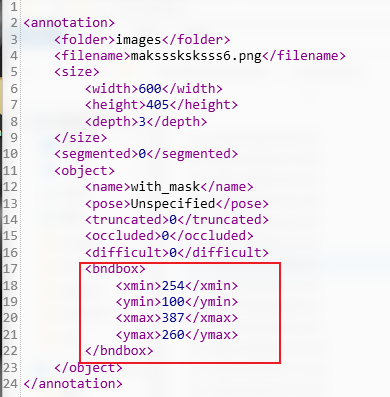


**这里四个参数代表了两个坐标点，即左上角(xmin,ymin)和右上角(xmax,ymax)**

**有这两个坐标就知道标注的矩形框的位置**

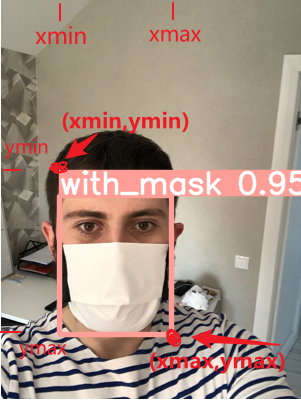

In [ ]:
def get_box(obj):
    x_min = int(obj.find('xmin').text)
    y_min = int(obj.find('ymin').text)
    x_max = int(obj.find('xmax').text)
    y_max = int(obj.find('ymax').text)

    return [x_min, y_min, x_max, y_max]

**获取label，这个数据集一共有三个类别**

**也就是获取这部分数据**

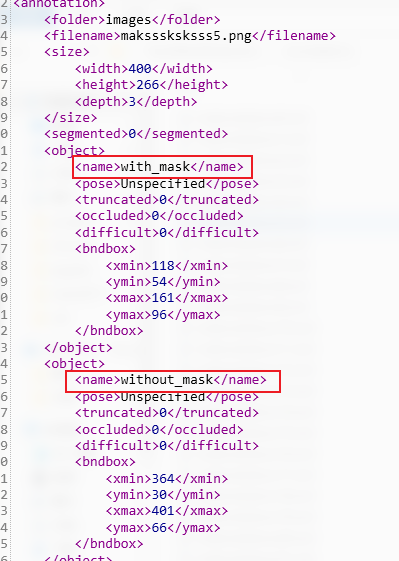

In [ ]:
def get_label(obj):
    if obj.find('name').text == 'with_mask':
        return 1
    elif obj.find('name').text == 'mask_weared_incorrect':
        return 2
    else:
        return 0

**同理获取文件名和图片尺寸，因为用的bs4解析所以获取到标签就可以了**

In [ ]:
def get_filename(obj):
    return obj.find('filename').text


def get_size(obj):
    w = int(obj.find('width').text)
    h = int(obj.find('height').text)

    return [w, h]

**把上面那些信息用一个列表来收集**

In [ ]:
# file就是需要转换的xml文件
def get_data_info(file):
    image_info = {}

    box = []
    label = []
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        obj = soup.find_all('object')
        annot = soup.find_all('annotation')

        for i in annot:
            image_info['filename'] = get_filename(i)
            image_info['image_size'] = get_size(i)

        for i in obj:
            box.append(get_box(i))
            label.append(get_label(i))

        image_info['bbox'] = box
        image_info['label'] = label
    return image_info

**把VOC的标识形式转换为yolov5格式**

**VOC格式是通过左上角右下角两个坐标来确定标识矩形，yolov5是通过中心点和图片宽高来确定**

In [ ]:
def convert_to_yolo(info):
    buffer = []
    boxes = info['bbox']
    size = info['image_size']
    image_w = size[0]
    image_h = size[1]
    # to iterate through labels list
    label_iter = 0

    for box in boxes:
        b_center_x = (box[0] + box[2]) / 2.0
        b_center_y = (box[1] + box[3]) / 2.0
        b_width = (box[2] - box[0])
        b_height = (box[3] - box[1])

        b_center_x /= image_w
        b_center_y /= image_h
        b_width /= image_w
        b_height /= image_h

        buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(info['label'][label_iter],
                              b_center_x, b_center_y, b_width, b_height))
        label_iter += 1

    save_dir_name = os.path.join(dataset_dir, 'labels')
    if not os.path.exists(save_dir_name):
        os.mkdir(save_dir_name)

    save_file_name = os.path.join(save_dir_name, info["filename"].replace("png", "txt"))

    # Save the annotation to disk
    with open(save_file_name, 'w') as f:
        f.write("\n".join(buffer))


**将 annotations 中的标注转换到 labelss 文件夹中**

**yolov5的数据文件夹格式：**

**├──data**

**└─────images**

**└─────labels**


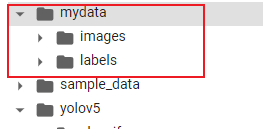

In [ ]:
dataset_dir = r'/content/drive/MyDrive/mydata'

annotations_dir = os.path.join(dataset_dir, 'annotations')
annotations_list = os.listdir(annotations_dir)

for i in range(len(annotations_list)):
    if annotations_list[0][-3:] == "xml":
        annotations_file = os.path.join(annotations_dir, annotations_list[i])
        info = get_data_info(annotations_file)
        # print(info)
        convert_to_yolo(info)

**用sklean划分测试集和训练集**

In [ ]:
def split_dataset() -> tuple:
    """Split dataset to 80% train and 20% val"""
    # Read images and annotations
    images = [os.path.join(images_dir, img_name) for img_name in
              os.listdir(images_dir)]
    annotations = [os.path.join(labels_dir, label_name) for label_name in os.listdir(labels_dir) if
                   label_name[-3:] == "txt"]

    images.sort()
    annotations.sort()

    # Split the dataset into train-valid-test splits
    train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.2)
    return train_images, val_images, train_annotations, val_annotations

**创建yolov5数据目录并把数据复制进去**

**目录结构：**

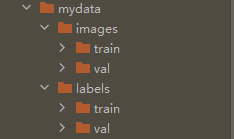

In [ ]:
def move_data() -> None:
    # make new directory for data
    dirs = ['mydata/images/train', 'mydata/images/val', 'mydata/labels/train',
            'mydata/labels/val']

    for dir in dirs:
        if not os.path.isdir(dir):
            os.makedirs(dir)

    data_tuple = split_dataset()
    # move the splits into their folders
    for data in data_tuple:
        for f in data:
            try:
                shutil.copy(f, dirs[data_tuple.index(data)])
            except:
                print(f)
                assert False

**创建yaml文件，yolov5通过指定这个文件来指定训练数据的位置和类别**

In [ ]:
def create_train_yaml() -> None:
    """Create YAML file for yolo model"""
    ROOT = os.getcwd()
    path = os.path.join(ROOT, 'mydata')

    mydata_yaml = f"""
path: {path}  # dataset root dir
train: images/train  # train images (relative to 'path') 128 images
val: images/val  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes
names:
  0: without_mask
  1: with_mask
  2: mask_weared_incorrect
"""

    with open('data/mydata.yaml', 'w') as f:
        f.write(mydata_yaml)

**把上面那个函数运行一下**

In [ ]:
move_data()
create_train_yaml()

In [ ]:
!python train.py --data /data/mydata.yaml --epochs 100 # 开始训练

train: weights=yolov5l.pt, cfg=, data=data/mydata.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=/content/yolov5/runs/train/exp2/weights/last.pt, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=

In [22]:
!python detect.py --weights /content/drive/MyDrive/best.pt --source /content/mydata/images/val

detect: weights=['/content/drive/MyDrive/best.pt'], source=/content/mydata/images/val, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.9.16 torch-2.0.0+cu118 CPU

Fusing layers... 
Model summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
image 1/213 /content/mydata/images/val/maksssksksss640.png: 352x640 9 with_masks, 1 mask_weared_incorrect, 1195.2ms
image 2/213 /content/mydata/images/val/maksssksksss641.png: 640x448 4 without_masks, 2037.1ms
image 3/213 /content/mydata/images/val/maksssksksss642.png: 640x416 2 with_masks, 1405.

In [23]:
import os 
folder = '/content/yolov5/runs/detect/exp5'
dirs = os.listdir(folder)
print(dirs[:5])
img_path = []
for i in dirs:
    img_path.append(i)
# img_path = [folder +"\\"+i for i in img_path]
img_path = [os.path.join(folder,i) for i in img_path]
print(img_path[:5])

['maksssksksss655.png', 'maksssksksss678.png', 'maksssksksss646.png', 'maksssksksss668.png', 'maksssksksss666.png']
['/content/yolov5/runs/detect/exp4/maksssksksss655.png', '/content/yolov5/runs/detect/exp4/maksssksksss678.png', '/content/yolov5/runs/detect/exp4/maksssksksss646.png', '/content/yolov5/runs/detect/exp4/maksssksksss668.png', '/content/yolov5/runs/detect/exp4/maksssksksss666.png']


In [24]:
from matplotlib import pyplot as plt
from keras.utils.image_utils import load_img

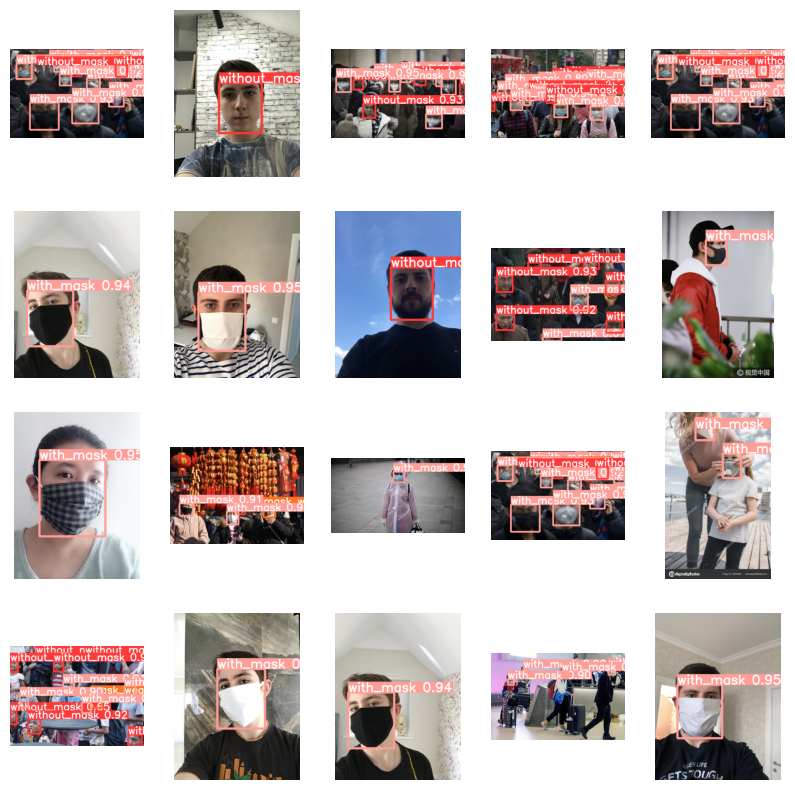

In [25]:
import random
fig1 = plt.figure(figsize=(10,10))
for i in range(4):
    for j in range(5):
        img = load_img(img_path[random.randint(0,len(img_path))])
        plt.subplot(4,5,i*5+j+1)
        plt.imshow(img)
        plt.axis("off")